## Kickstarter projects: an exercise in basic feature engineering

In [1]:
# try 2 - 2 months later
# i won't be able to remember much 

In [2]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# sklearn- model selection
from sklearn.model_selection import train_test_split

# sklearn- models  
from sklearn.ensemble import RandomForestClassifier

# sklearn- metrics 
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report

# category_encoders
from category_encoders import CountEncoder, TargetEncoder

import itertools

In [3]:
# load the dataset 
ks_data = pd.read_csv('../data/raw/ks-projects-201801.csv', parse_dates=['deadline','launched'])

# inspect
ks_data.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


In [4]:
# check datatypes
ks_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378661 entries, 0 to 378660
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   ID                378661 non-null  int64         
 1   name              378657 non-null  object        
 2   category          378661 non-null  object        
 3   main_category     378661 non-null  object        
 4   currency          378661 non-null  object        
 5   deadline          378661 non-null  datetime64[ns]
 6   goal              378661 non-null  float64       
 7   launched          378661 non-null  datetime64[ns]
 8   pledged           378661 non-null  float64       
 9   state             378661 non-null  object        
 10  backers           378661 non-null  int64         
 11  country           378661 non-null  object        
 12  usd pledged       374864 non-null  float64       
 13  usd_pledged_real  378661 non-null  float64       
 14  usd_

In [5]:
# create a copy of the dataset so that it doens't need to be reloaded
kickstarter = ks_data.copy()

## 1. Baseline Model

In this step we create a simple model using the features already available in the dataset. We will then use the performance metrics of our baseline model as a benchmark to judge the performance of more complex models with engineered features. 

Features in the baseline model:
* launched date (broken down into three int features: year, month and day)
* main_category 
* category 
* country
* ~~goal~~ (as there are multiple currencies in the dataset, this will only work if we focus on USD)

### Preparing target column

In [6]:
# find out which state can be used as our target variable
kickstarter['state'].value_counts()

failed        197719
successful    133956
canceled       38779
undefined       3562
live            2799
suspended       1846
Name: state, dtype: int64

For the purpose of our model we will consider `successful` projects as 1 (=success) and everything else will be regarded as 0 (=failed). We will also drop `live` projects. 

In [7]:
# create our target feature
kickstarter = kickstarter.assign(is_successful = (kickstarter['state'] == 'successful').astype(int))

# check 
kickstarter.groupby(['state','is_successful'])['name'].count().reset_index()

,state,is_successful,name
0,canceled,0,38779
1,failed,0,197716
2,live,0,2799
3,successful,1,133956
4,suspended,0,1845
5,undefined,0,3562


In [8]:
# drop live projects 
kickstarter = kickstarter.query('state != "live"')

# drop projects where the goal currency != USD
kickstarter = kickstarter[kickstarter['currency'] == 'USD']

### Converting timestamps

In [9]:
# create a function that can turn any date column into year, month and day
def date_to_int(df, col):
    year = df[col].dt.year
    month = df[col].dt.month
    day = df[col].dt.day
    return year, month, day

In [10]:
# convert laucnehd date into its date components 
launched_year, launched_month, launched_day = date_to_int(kickstarter, 'launched')

# save them into a DataFrame that can be appended later
launched_ymd = pd.concat([launched_year, launched_month, launched_day], axis=1, keys=['year','month','day'])

# inspect
pd.DataFrame(kickstarter['launched']).join(launched_ymd).head()

,launched,year,month,day
1,2017-09-02 04:43:57,2017,9,2
2,2013-01-12 00:20:50,2013,1,12
3,2012-03-17 03:24:11,2012,3,17
4,2015-07-04 08:35:03,2015,7,4
5,2016-02-26 13:38:27,2016,2,26


### Processing categorical variables

In [11]:
# select categorical variables
categorical_cols = ['category','main_category','country']

In [12]:
# Approach 1: label encoder 
from sklearn.preprocessing import LabelEncoder

# instantiate 
le = LabelEncoder()

# apply encoder
encoded_le = kickstarter[categorical_cols].apply(le.fit_transform)

# inspect
encoded_le.head()

,category,main_category,country
1,93,6,1
2,93,6,1
3,90,10,1
4,55,6,1
5,123,7,1


### Processing numerical variables

Text(0.5, 1.0, 'Distribution of "Goal"')

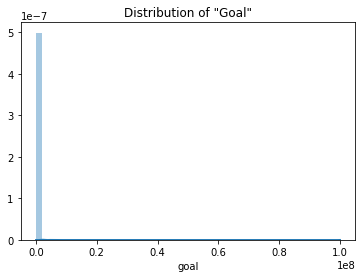

In [13]:
# examine the distribution of 'goal', our only numerical variable 
# plot distribution
sns.distplot(kickstarter['goal'])

# add annotations
plt.title('Distribution of "Goal"')

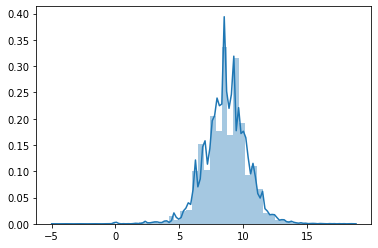

In [14]:
# use log transformation to normalise the distribution a little 
goal_log = pd.DataFrame(np.log(kickstarter['goal']))

# plot again 
sns.distplot(goal_log)

### Creating a dataset for the baseline model

In [15]:
# create a new DataFrame with just the features we want to train the baseline model on
model_df = kickstarter[['is_successful']].join(launched_ymd).join(encoded_le).join(goal_log)

# inspect
model_df.head()

,is_successful,year,month,day,category,main_category,country,goal
1,0,2017,9,2,93,6,1,10.308953
2,0,2013,1,12,93,6,1,10.714418
3,0,2012,3,17,90,10,1,8.517193
4,0,2015,7,4,55,6,1,9.878170
5,1,2016,2,26,123,7,1,10.819778


### Examine correlations between these variables and target


In [16]:
# select a couple of features to look at 
examine_cols = ['year','month','main_category']

# calculate the overall succcess rate 
success_rate = model_df['is_successful'].mean()

# create an empty DataFrame to store all stats 
stats_df = pd.DataFrame()

# for each feature 
for col in examine_cols:
    
    # calculate group size, % successful and diff in % successful compared to overall success rate
    grouped = model_df.groupby(col)
    group_size = grouped['is_successful'].size()
    group_success = grouped['is_successful'].mean()
    group_diff = group_success - success_rate
    
    # combine them together 
    feature_stats = pd.concat([group_size, group_success, group_diff], axis=1, keys=['size','success_rate','diff_from_mean'])
    
    # 
    feature_stats.reset_index(inplace=True)
    feature_stats['feature_name'] = col
    feature_stats.rename(columns={col:'feature_value'}, inplace=True)
    
    # append to main df
    stats_df = stats_df.append(feature_stats)
    

In [17]:
# inspect stats 
stats_df.head()

,feature_value,size,success_rate,diff_from_mean,feature_name
0,1970,6,0.000000,-0.372514,year
1,2009,1329,0.435666,0.063152,year
2,2010,10519,0.436638,0.064125,year
3,2011,26237,0.463887,0.091373,year
4,2012,40549,0.436657,0.064143,year


In [18]:
# examine year 
feature_year = stats_df[stats_df['feature_name']=='year'].sort_values('feature_value')

(-0.15, 0.15)

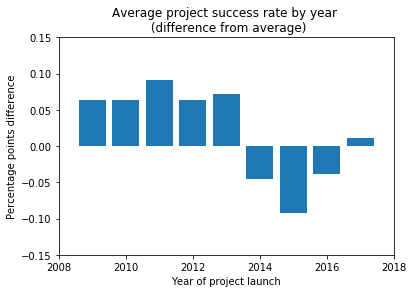

In [19]:
# annotate
plt.title('Average project success rate by year \n (difference from average)')
plt.xlabel('Year of project launch')
plt.ylabel('Percentage points difference')

# plot year 
plt.bar(feature_year['feature_value'], feature_year['diff_from_mean'])
plt.xlim(2008,2018)
plt.ylim(-0.15, 0.15)

In [20]:
# examine categories 
feature_main_category = stats_df[stats_df['feature_name']=='main_category'].sort_values('feature_value')

<BarContainer object of 15 artists>

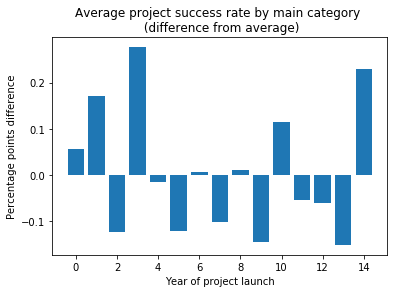

In [21]:
# annotate
plt.title('Average project success rate by main category \n (difference from average)')
plt.xlabel('Year of project launch')
plt.ylabel('Percentage points difference')

# plot year 
plt.bar(feature_main_category['feature_value'], feature_main_category['diff_from_mean'])

### Create train and test datasets

In [22]:
# create a function that will split the dataset in the same way
def create_train_test(df):
    
    # create X, y
    X = model_df.drop('is_successful', axis=1)
    y = model_df['is_successful']
    
    # split into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    return X, y, X_train, X_test, y_train, y_test


In [23]:
# split our dataset
X, y, X_train, X_test, y_train, y_test = create_train_test(model_df)

In [24]:
# check that we have rougly the same % of successful projects in train and test
print('% successful (train): {:.2%}'.format(y_train.mean()))
print('% successful (test): {:.2%}'.format(y_test.mean()))

% successful (train): 37.26%
% successful (test): 37.20%


**Warning:** class imbalance. We're addressing it by using a tree-based algorithm and using ROC AUC as our classification metric.

### Training a RandomForest model

In [25]:
# create a function that will fit, predict and score our model automatically
def score_model(X_train, X_test, y_train, y_test):
    
    # instantiate 
    rfc = RandomForestClassifier(min_samples_leaf=5, random_state=42)
    
    # fit 
    print('Fitting...')
    rfc.fit(X_train, y_train)
    
    # predict
    print('Predicting...')
    y_pred = rfc.predict(X_test)
    y_pred_train = rfc.predict(X_train)
    
    # scoring
    print('Done.')
    roc = roc_auc_score(y_test, y_pred)
    roc_train = roc_auc_score(y_train, y_pred_train)

    print('ROC AUC (test): {:.2%}'.format(roc))
    print('ROC AUC (train): {:.2%}'.format(roc_train))
    
    #return roc, roc_train


In [26]:
# fit, predict and score our baseline model
score_model(X_train, X_test, y_train, y_test)

Fitting...
Predicting...
Done.
ROC AUC (test): 63.21%
ROC AUC (train): 75.68%


## 2. Alternative categorical encodings

`LabelEncoder` was used for our basline model but there are many other categorical encoders that we could try: 
* `pd.get_dummies` = creates n new columns where n is the number of unique values (categories) in each feature. Can create very sparse matrices which increase the computational time
* `CountEncoder` = useful to separate rare categories from those which are more common
* `TargetEncoder` = encodes categorical variables based on what % of them appear associated with the target feature

### get_dummies

In [27]:
# encode categorical variables using get_dummies
encoded_dummies = pd.get_dummies(kickstarter[categorical_cols])

# inspect
encoded_dummies.head()

,category_3D Printing,category_Academic,category_Accessories,category_Action,category_Animals,category_Animation,category_Anthologies,category_Apparel,category_Apps,category_Architecture,...,main_category_Food,main_category_Games,main_category_Journalism,main_category_Music,main_category_Photography,main_category_Publishing,main_category_Technology,main_category_Theater,"country_N,0""",country_US
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1


In [28]:
# construct our dataset
model_df = kickstarter[['is_successful']].join(launched_ymd).join(encoded_dummies).join(goal_log)

In [29]:
# split into test, train
X, y, X_train, X_test, y_train, y_test = create_train_test(model_df)

In [30]:
# fit and score our rfc
score_model(X_train, X_test, y_train, y_test)

Fitting...
Predicting...
Done.
ROC AUC (test): 63.37%
ROC AUC (train): 71.63%


Our latest model performed `0.16` points **better** than baseline. 

### CountEncoder

In [31]:
# instantiate 
ce = CountEncoder(cols=categorical_cols)

# fit 
encoded_ce = ce.fit_transform(kickstarter[categorical_cols])

# inspect
encoded_ce.head()

,category,main_category,country
1,4761,52343,290887
2,4761,52343,290887
3,13305,44810,290887
4,8511,52343,290887
5,2147,19812,290887


In [32]:
# construct our dataset
model_df = kickstarter[['is_successful']].join(launched_ymd).join(encoded_ce).join(goal_log)

In [33]:
# split into train, test
X, y, X_train, X_test, y_train, y_test = create_train_test(model_df)

In [34]:
# fit and score our rfc
score_model(X_train, X_test, y_train, y_test)

Fitting...
Predicting...
Done.
ROC AUC (test): 63.27%
ROC AUC (train): 76.27%


Our latest model with `CountEncoder` performed `0.06` percentage points **better** than baseline.

### TargetEncoder

`TargetEncoder` needs to be fitted only on the training part of the dataset to avoid data leakage into the testing dataset.

In [35]:
# construct our dataset
model_df = kickstarter[['is_successful']].join(launched_ymd).join(kickstarter[categorical_cols]).join(goal_log)

In [36]:
# split into test, train
X, y, X_train, X_test, y_train, y_test = create_train_test(model_df)

In [37]:
# instantiate te
te = TargetEncoder(cols=categorical_cols)

# fit on just the training dataset
te.fit(X_train[categorical_cols], y=y_train)

# now, transform categorical variables in both train and test datasets
encoded_te_train = te.transform(X_train[categorical_cols])
encoded_te_test = te.transform(X_test[categorical_cols])

In [38]:
# drop the original categorical variables from train and test
X_train = X_train.drop(categorical_cols, axis=1)
X_test = X_test.drop(categorical_cols, axis=1)

In [39]:
# append TargetEncoder encoded categorical variables into train and test
X_train = X_train.join(encoded_te_train.add_suffix('_te'))
X_test = X_test.join(encoded_te_test.add_suffix('_te'))

# inspect train
X_train.head()

,year,month,day,goal,category_te,main_category_te,country_te
180788,2015,4,10,7.824046,0.433696,0.485114,0.027853
149390,2014,10,25,8.922658,0.381818,0.377948,0.375944
75367,2014,3,19,6.363028,0.311459,0.377948,0.375944
83109,2014,12,5,10.532123,0.433696,0.485114,0.375944
169314,2013,6,14,8.699515,0.693817,0.658039,0.375944


In [40]:
# fit and score our rfc
score_model(X_train, X_test, y_train, y_test)

Fitting...
Predicting...
Done.
ROC AUC (test): 63.73%
ROC AUC (train): 75.82%


Our latest model with `TargetEncoder` performed `0.52` percentage points **better** than baseline.

## 3. Feature generation

### Interactions

One of the easiest ways to generate features is to combine existing features with tools such as `intertools.combinations`.

In [41]:
# inspect our dataset
kickstarter.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real,is_successful
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.0,0
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.0,0
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.0,0
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.0,0
5,1000014025,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01,50000.0,2016-02-26 13:38:27,52375.0,successful,224,US,52375.0,52375.0,50000.0,1


In [42]:
# show categorical cols
categorical_cols

['category', 'main_category', 'country']

In [43]:
# create an empty DataFrame for the output from itertools
interactions = pd.DataFrame(index=kickstarter.index)

# loop through all combination pairs generated by itertools
for col1, col2 in itertools.combinations(categorical_cols, 2):
    
    # create a name of the new feature 
    # col_name = str(col1) + '__' +str(col2) # approach 1
    col_name = '__'.join([col1,col2]) # approach 2
    
    # combine feature values 
    col_values = kickstarter[col1].astype(str) + '__' + kickstarter[col2].astype(str) # approach 1 (faster)
    # col_values = kickstarter[[col1,col2]].astype(str).agg('__'.join, axis=1) # approach 2 (slow)
    
    # save into our interactions DataFrame
    interactions[col_name] = col_values

# inspect
interactions.head()

,category__main_category,category__country,main_category__country
1,Narrative Film__Film & Video,Narrative Film__US,Film & Video__US
2,Narrative Film__Film & Video,Narrative Film__US,Film & Video__US
3,Music__Music,Music__US,Music__US
4,Film & Video__Film & Video,Film & Video__US,Film & Video__US
5,Restaurants__Food,Restaurants__US,Food__US


In [44]:
# encode categorical with LabelEncoder
le = LabelEncoder()

# fit & transform
encoded_interactions = interactions.apply(le.fit_transform)

# inspect
encoded_interactions.head()

,category__main_category,category__country,main_category__country
1,101,104,10
2,101,104,10
3,99,101,16
4,62,60,10
5,131,137,11


In [45]:
# create a dataset for our model
model_df = kickstarter[['is_successful']].join(launched_ymd).join(encoded_interactions).join(goal_log).join(encoded_le)

In [46]:
# split into train, test
X, y, X_train, X_test, y_train, y_test = create_train_test(model_df)

In [47]:
# fit and score our rfc
score_model(X_train, X_test, y_train, y_test)

Fitting...
Predicting...
Done.
ROC AUC (test): 63.75%
ROC AUC (train): 75.55%


Our latest model with `3` new features created with `itertools.combinations` performed `0.54` percentage points **better** than baseline.

### Number of projects launched in the last 7 days

In [48]:
# let's index all projects by their launched date, order from oldest to newest
launched = pd.Series(kickstarter.index, index=kickstarter.launched).sort_index()
launched[:10]

launched
1970-01-01 01:00:00     94579
1970-01-01 01:00:00    247913
1970-01-01 01:00:00      2842
1970-01-01 01:00:00     75397
1970-01-01 01:00:00     48147
1970-01-01 01:00:00    273779
2009-04-21 21:02:48    169268
2009-04-23 00:07:53    322000
2009-04-24 21:52:03    138572
2009-04-25 17:36:21    325391
dtype: int64

In [49]:
# calculate a rolling 7 day count of projects 
launched_r7d = launched.rolling('7D').count() -1

# change the index from 'launched date' back to the oringal index 
launched_r7d.index = launched.values

# reindex (reorder to match the original dataset)
launched_r7d = launched_r7d.reindex(kickstarter.index)

# give it a name 
launched_r7d.name = 'last_7d_cnt'

# inspect
launched_r7d[:10]

1      570.0
2      661.0
3      907.0
4      981.0
5      844.0
6      739.0
7      941.0
8      828.0
9     2374.0
11     787.0
Name: last_7d_cnt, dtype: float64

### Time since the last project in the same category

In [50]:
# grab the data and order it by launch date
launched_cat = kickstarter[['launched','category']].sort_values('launched')
launched_cat.head()

,launched,category
94579,1970-01-01 01:00:00,Theater
247913,1970-01-01 01:00:00,Music
2842,1970-01-01 01:00:00,Film & Video
75397,1970-01-01 01:00:00,Film & Video
48147,1970-01-01 01:00:00,Art


In [51]:
# group by category 
grouped = launched_cat.groupby('category')

# create a function that will be applied to the group object
def calculate_td(series):
    """ Calculate the difference in hours between the current project
    and the previous project in same category."""
    return series.diff().dt.total_seconds() / 3600

In [52]:
# calculate difference in hours between the current and previous project by category
td_7days = grouped.transform(calculate_td)

# where a project is the first one in its category to launch in the 7 day period, replace NaN with 0
td_7days = td_7days.fillna(0).reindex(kickstarter.index)

# give it a name 
td_7days.rename(columns={'launched':'hrs_since_last_in_cat'}, inplace=True)

# inspect
td_7days

,hrs_since_last_in_cat
1,5.592778
2,1.313611
3,0.635000
4,26.083889
5,2.629722
...,...
378656,2.659167
378657,3.835833
378658,20.575278
378659,0.614444


### Number of projects in the same category launched in the past 28 days

In [53]:
# grab the data and set 'launched' as index because it's required for .rolling()
launched_cat = kickstarter[['launched','category']].reset_index().set_index('launched').sort_index()
launched_cat.head()

,index,category
launched,,
1970-01-01 01:00:00,94579,Theater
1970-01-01 01:00:00,247913,Music
1970-01-01 01:00:00,2842,Film & Video
1970-01-01 01:00:00,75397,Film & Video
1970-01-01 01:00:00,48147,Art


In [54]:
# define function 
def calculate_rolling_n(series):
    return series.rolling('28D').count() -1 

In [55]:
# group by category
grouped = launched_cat.groupby('category')

# calculate how many projects launched in the same cat in the 28 days prior
n_launched_28d = grouped.transform(calculate_rolling_n)

# change index and reindex to match the original dataset
n_launched_28d.index = launched_cat['index']
n_launched_28d = n_launched_28d.reindex(kickstarter.index)

# rename it 
n_launched_28d.rename(columns={'index':'last_28d_cnt_in_cat'}, inplace=True)

# inspect
n_launched_28d

,last_28d_cnt_in_cat
1,12.0
2,32.0
3,212.0
4,67.0
5,46.0
...,...
378656,164.0
378657,91.0
378658,36.0
378659,49.0


In [56]:
# verify that when project 3 launched, 212 other projects in the same category
# had already launched in the 28 days prior 
kickstarter.loc[3,['category','launched']]

category                  Music
launched    2012-03-17 03:24:11
Name: 3, dtype: object

In [57]:
# create conditions to find all projects created in that period from the same cat as proj 3
to_date = pd.Timestamp(2012,3,17,3,24,11)
from_date = to_date - pd.Timedelta(days=28)

f1 = kickstarter['category'] == 'Music'
f2 = kickstarter['launched'] >= from_date
f3 = kickstarter['launched'] < to_date 

In [58]:
len(kickstarter[f1 & f2 & f3])

212

In [59]:
# create a clean dataset for our model
model_df = kickstarter[['is_successful']].join(launched_ymd).join(goal_log).join(encoded_le).join(launched_r7d) \
    .join(td_7days).join(n_launched_28d)

# inspect
model_df.head()

,is_successful,year,month,day,goal,category,main_category,country,last_7d_cnt,hrs_since_last_in_cat,last_28d_cnt_in_cat
1,0,2017,9,2,10.308953,93,6,1,570.0,5.592778,12.0
2,0,2013,1,12,10.714418,93,6,1,661.0,1.313611,32.0
3,0,2012,3,17,8.517193,90,10,1,907.0,0.635000,212.0
4,0,2015,7,4,9.878170,55,6,1,981.0,26.083889,67.0
5,1,2016,2,26,10.819778,123,7,1,844.0,2.629722,46.0


In [60]:
# split into train, test
X, y, X_train, X_test, y_train, y_test = create_train_test(model_df)

In [61]:
# fit and score our rfc
score_model(X_train, X_test, y_train, y_test)

Fitting...
Predicting...
Done.
ROC AUC (test): 63.20%
ROC AUC (train): 84.47%


Our latest model with `3` new engineered columns based on project-wise timedeltas performed `0.01` percentage points **worse** than baseline.

## 4. Feature Selection

### Univariate Feature Selection

We can use `feature_selection.SelectKBest` from sklearn to quickly select k number of features. The tool provides three scoring functions for classfication problems: 
* x^2
* ANOVA F-value
* mutual information score

The F-value measures the linear dependency between the feature variable and the target. This means the score might underestimate the relation between a feature and the target if the relationship is nonlinear.

In [62]:
# construct our dataset with all potential features 
model_df = kickstarter[['is_successful']].join(encoded_le).join(launched_ymd).join(goal_log).join(launched_r7d) \
    .join(td_7days).join(n_launched_28d).join(encoded_interactions)

# inspect
model_df.head()

,is_successful,category,main_category,country,year,month,day,goal,last_7d_cnt,hrs_since_last_in_cat,last_28d_cnt_in_cat,category__main_category,category__country,main_category__country
1,0,93,6,1,2017,9,2,10.308953,570.0,5.592778,12.0,101,104,10
2,0,93,6,1,2013,1,12,10.714418,661.0,1.313611,32.0,101,104,10
3,0,90,10,1,2012,3,17,8.517193,907.0,0.635000,212.0,99,101,16
4,0,55,6,1,2015,7,4,9.878170,981.0,26.083889,67.0,62,60,10
5,1,123,7,1,2016,2,26,10.819778,844.0,2.629722,46.0,131,137,11


In [63]:
# to avoid introducing leakage we must apply the SelectKBest on our training dataset only.
X, y, X_train, X_test, y_train, y_test = create_train_test(model_df)

In [64]:
# import module
from sklearn.feature_selection import SelectKBest, f_classif

# instantiate 
selector = SelectKBest(f_classif, k=5)

# fit & transform
X_train_new = selector.fit_transform(X_train, y_train)

# inspect
X_train_new

array([[1.00000000e+01, 0.00000000e+00, 2.01500000e+03, 7.82404601e+00,
        1.32700000e+03],
       [6.00000000e+00, 1.00000000e+00, 2.01400000e+03, 8.92265830e+00,
        1.09600000e+03],
       [6.00000000e+00, 1.00000000e+00, 2.01400000e+03, 6.36302810e+00,
        8.12000000e+02],
       ...,
       [1.00000000e+00, 1.00000000e+00, 2.01200000e+03, 8.85366543e+00,
        8.58000000e+02],
       [1.00000000e+01, 1.00000000e+00, 2.01200000e+03, 8.69951475e+00,
        6.81000000e+02],
       [0.00000000e+00, 1.00000000e+00, 2.01700000e+03, 9.90348755e+00,
        6.50000000e+02]])

In [65]:
# get back the features we've kept, zero out all other features
selected_features = pd.DataFrame(
    selector.inverse_transform(X_train_new), 
    index=X_train.index, 
    columns=X_train.columns)

# inspect
selected_features.head()

,category,main_category,country,year,month,day,goal,last_7d_cnt,hrs_since_last_in_cat,last_28d_cnt_in_cat,category__main_category,category__country,main_category__country
180788,0.0,10.0,0.0,2015.0,0.0,0.0,7.824046,1327.0,0.0,0.0,0.0,0.0,0.0
149390,0.0,6.0,1.0,2014.0,0.0,0.0,8.922658,1096.0,0.0,0.0,0.0,0.0,0.0
75367,0.0,6.0,1.0,2014.0,0.0,0.0,6.363028,812.0,0.0,0.0,0.0,0.0,0.0
83109,0.0,10.0,1.0,2014.0,0.0,0.0,10.532123,938.0,0.0,0.0,0.0,0.0,0.0
169314,0.0,3.0,1.0,2013.0,0.0,0.0,8.699515,836.0,0.0,0.0,0.0,0.0,0.0


In [66]:
# only select those features that are non-null 
selected_columns = selected_features.columns[selected_features.var() != 0]

X_train[selected_columns].head()

,main_category,country,year,goal,last_7d_cnt
180788,10,0,2015,7.824046,1327.0
149390,6,1,2014,8.922658,1096.0
75367,6,1,2014,6.363028,812.0
83109,10,1,2014,10.532123,938.0
169314,3,1,2013,8.699515,836.0


### L1 regularization

Univariate methods consider only one feature at a time when making a selection decision. Instead, we can make our selection using all of the features by including them in a linear model with L1 regularization. 

This type of regularization (sometimes called Lasso) penalizes the absolute magnitude of the coefficients, as compared to L2 (Ridge) regression which penalizes the square of the coefficients.

In [67]:
# import modules 
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel

In [68]:
# select data
model_df = kickstarter[['is_successful']].join(encoded_le).join(launched_ymd).join(goal_log).join(launched_r7d) \
    .join(td_7days).join(n_launched_28d).join(encoded_interactions)

# inspect
model_df.head()

,is_successful,category,main_category,country,year,month,day,goal,last_7d_cnt,hrs_since_last_in_cat,last_28d_cnt_in_cat,category__main_category,category__country,main_category__country
1,0,93,6,1,2017,9,2,10.308953,570.0,5.592778,12.0,101,104,10
2,0,93,6,1,2013,1,12,10.714418,661.0,1.313611,32.0,101,104,10
3,0,90,10,1,2012,3,17,8.517193,907.0,0.635000,212.0,99,101,16
4,0,55,6,1,2015,7,4,9.878170,981.0,26.083889,67.0,62,60,10
5,1,123,7,1,2016,2,26,10.819778,844.0,2.629722,46.0,131,137,11


In [69]:
# split dataset
X, y, X_train, X_test, y_train, y_test = create_train_test(model_df)

In [70]:
# Set the regularization parameter C=1
logistic = LogisticRegression(C=1, penalty='l1', solver='liblinear', random_state=42)

# fit 
logistic.fit(X_train, y_train) 
model = SelectFromModel(logistic, prefit=True)

# transform
X_train_new = model.transform(X_train)

# inspect
X_train_new

array([[ 90.,  10.,   0., ...,  99., 100.,  15.],
       [ 39.,   6.,   1., ...,  43.,  41.,  10.],
       [ 55.,   6.,   1., ...,  62.,  60.,  10.],
       ...,
       [ 26.,   1.,   1., ...,  30.,  27.,   1.],
       [ 72.,  10.,   1., ...,  79.,  81.,  16.],
       [ 96.,   0.,   1., ..., 104., 107.,   0.]])

In [71]:
# get back the features we've kept, zero out all other features
selected_features = pd.DataFrame(
    model.inverse_transform(X_train_new), 
    index=X_train.index, 
    columns=X_train.columns)

# only select those features that are non-null 
selected_columns = selected_features.columns[selected_features.var() !=0]

# inspect
X_train[selected_columns].head()

,category,main_category,country,year,month,day,goal,last_7d_cnt,last_28d_cnt_in_cat,category__main_category,category__country,main_category__country
180788,90,10,0,2015,4,10,7.824046,1327.0,204.0,99,100,15
149390,39,6,1,2014,10,25,8.922658,1096.0,146.0,43,41,10
75367,55,6,1,2014,3,19,6.363028,812.0,138.0,62,60,10
83109,90,10,1,2014,12,5,10.532123,938.0,149.0,99,101,16
169314,36,3,1,2013,6,14,8.699515,836.0,40.0,40,38,4


In [72]:
set(X_train.columns).difference(set(X_train[selected_columns]))

{'hrs_since_last_in_cat'}

With L1 regularization (Lasso) and its parameter C set to `1` we're only dropping the `hrs_since_last_in_cat` feature from the dataset. Note: like in support vector machines, smaller values of `C` specify stronger regularization.

In [ ]:
# Function which selects the best features based on L1 regularization (example):
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel

def select_features_l1(X, y):
    """Return selected features using logistic regression with an L1 penalty."""
    # instantiate LogisticRegression()
    logreg = LogisticRegression(penalty='l1', C=0.1, solver='liblinear', random_state=7)
    # fit 
    logreg.fit(X, y)
    model = SelectFromModel(logreg, prefit=True)
    # transform 
    X_new = model.transform(X)
    # select feature names which are not all nulls / zeros
    features = pd.DataFrame(
        model.inverse_transform(X_new),
        index = X.index,
        columns = X.columns)
    
    selected_features = features.columns[features.var() > 0]

    return selected_features